# Saddle Point Solver (using Scipy)

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
from matplotlib import pyplot
import numpy
from scipy.sparse import bmat, linalg
from dune.grid import cartesianDomain
from dune.alugrid import aluCubeGrid
from dune.fem.space import lagrange
from dune.fem.operator import galerkin as galerkinOperator
from dune.fem.scheme import galerkin as galerkinScheme
from ufl import SpatialCoordinate, CellVolume, TrialFunction, TestFunction,\
                inner, dot, div, grad, dx, as_vector, transpose, Identity
from dune.ufl import Constant, DirichletBC
import dune.fem
from dune.fem.operator import linear as linearOperator


order = 2
grid = aluCubeGrid(constructor=cartesianDomain([0,0],[3,1],[30,10]))
spcU = lagrange(grid, dimRange=grid.dimension, order=order, storage="fem")
spcP = lagrange(grid, dimRange=1, order=order-1, storage="fem")

cell  = spcU.cell()
x     = SpatialCoordinate(cell)
mu    = Constant(0, "mu")
nu    = Constant(0, "nu")
u     = TrialFunction(spcU)
v     = TestFunction(spcU)
p     = TrialFunction(spcP)
q     = TestFunction(spcP)
exact_u     = as_vector( [x[1] * (1.-x[1]), 0] )
exact_p     = as_vector( [ (-2*x[0] + 2)*mu ] )
f           = as_vector( [0,]*grid.dimension )
f          += nu*exact_u
mainModel   = (nu*dot(u,v) + mu*inner(grad(u)+grad(u).T, grad(v)) - dot(f,v)) * dx
gradModel   = -inner( p[0]*Identity(grid.dimension), grad(v) ) * dx
divModel    = -div(u)*q[0] * dx
massModel   = inner(p,q) * dx
preconModel = inner(grad(p),grad(q)) * dx

# can also use 'operator' everywhere
mainOp      = galerkinOperator( (mainModel==0,DirichletBC(spcU,exact_u,1)), spcU)
gradOp      = galerkinOperator(gradModel,spcP,spcU)
divOp       = galerkinOperator(divModel,spcU,spcP)
massOp      = galerkinOperator(massModel==0,spcP)
preconOp    = galerkinOperator(preconModel==0,spcP)

mainOp.model.mu = 0.1
mainOp.model.nu = 0.01

velocity = spcU.interpolate([0,]*spcU.dimRange, name="velocity")
pressure = spcP.interpolate([0], name="pressure")
rhsVelo  = velocity.copy()
rhsPress = pressure.copy()

sol_u  = velocity.as_numpy
sol_p  = pressure.as_numpy
rhs_u  = rhsVelo.as_numpy
rhs_p  = rhsPress.as_numpy
r      = numpy.copy(rhs_p)
d      = numpy.copy(rhs_p)
precon = numpy.copy(rhs_p)
xi     = numpy.copy(rhs_u)
A = linearOperator(mainOp).as_numpy
G = linearOperator(gradOp).as_numpy
D = linearOperator(divOp).as_numpy
M = linearOperator(massOp).as_numpy
P = linearOperator(preconOp).as_numpy
def Ainv(rhs,target): target[:] = linalg.spsolve(A,rhs)
def Minv(rhs,target): target[:] = linalg.spsolve(M,rhs)
def Pinv(rhs,target): target[:] = linalg.spsolve(P,rhs)

mainOp(velocity,rhsVelo)
rhs_u *= -1
xi[:] = G*sol_p
rhs_u -= xi
mainOp.setConstraints(rhsVelo)

Ainv(rhs_u[:], sol_u[:])
rhs_p[:] = D*sol_u
Minv(rhs_p, r)
if mainOp.model.nu > 0:
    precon.fill(0)
    Pinv(rhs_p, precon)
    r *= mainOp.model.mu
    r += mainOp.model.nu*precon
d[:] = r[:]
delta = numpy.dot(r,rhs_p)
for m in range(100):
    xi.fill(0)
    rhs_u[:] = G*d
    mainOp.setConstraints([0,]*grid.dimension, rhsVelo)
    Ainv(rhs_u[:], xi[:])
    rhs_p[:] = D*xi
    rho = delta / numpy.dot(d,rhs_p)
    sol_p += rho*d
    sol_u -= rho*xi
    rhs_p[:] = D*sol_u
    Minv(rhs_p[:],r[:])
    if mainOp.model.nu > 0:
        precon.fill(0)
        Pinv(rhs_p,precon)
        r *= mainOp.model.mu
        r += mainOp.model.nu*precon
    oldDelta = delta
    delta = numpy.dot(r,rhs_p)
    if delta < 1e-14: break
    gamma = delta/oldDelta
    d *= gamma
    d += r

Now we can easily plot the velocity magnitude and pressure

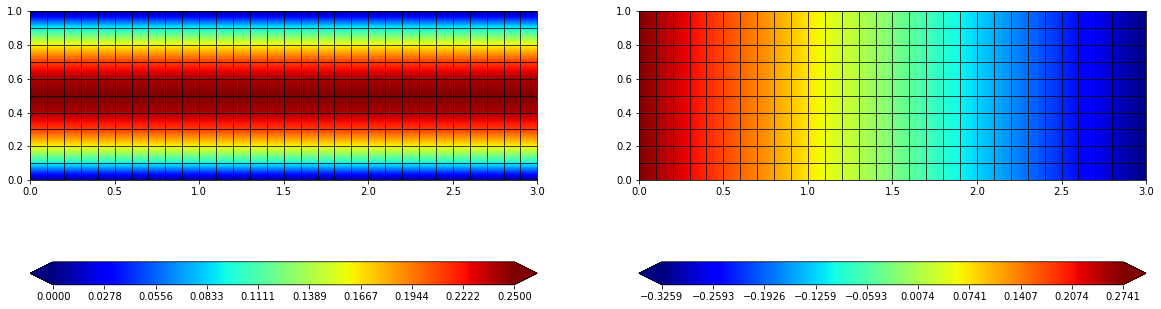

In [2]:
fig = pyplot.figure(figsize=(20,10))
velocity.plot(colorbar="horizontal", figure=(fig, 121))
pressure.plot(colorbar="horizontal", figure=(fig, 122))
pyplot.show()